![Patrones](https://drive.google.com/uc?export=view&id=1FVBEDeOK1dmp3cpfhbq82lA-eI0ZZJW1)

# **`Challenge 6 `**

# <center>Implementación de optimización de hiperparámetros y pipeline en una clasificación de Random Forest</center>
    
### Acerca de los datos

​**Este conjunto de datos contiene 2126 registros de características extraídas de exámenes de Cardiotocograma, que luego fueron clasificados por un obstetra experto en 3 clases: "Normal", "Suspect" y "Pathological". El conjunto de datos contiene las siguientes características:**

<br>

Datos extraidos de :

https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification <br>

<br>

Base de datos usada: <br>
    `Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318`. [<small>DOI: 10.1002/1520-6661(200009/10)9:5<311::AID-MFM12>3.0.CO;2-9</small>](https://doi.org/10.1002/1520-6661(200009/10)9:5%3C311::AID-MFM12%3E3.0.CO;2-9)
<br>



# Carga y preprocesamiento de datos
Al cargar los datos, no se encontraron nulos para ninguna de las características, todas están en formato numérico, por lo que no se requiere de mucho preprocesamiento.

In [1]:
import pandas as pd # feature selection

In [2]:
df = pd.read_csv("https://github.com/ulewis/Ejemplos/raw/main/Datos/fetal_health.csv")
df.head()  # vemos los 5 primeros datos del dataframe

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [3]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()
missing_values


baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [4]:
df.dtypes #

baseline value                                            float64
accelerations                                             float64
fetal_movement                                            float64
uterine_contractions                                      float64
light_decelerations                                       float64
severe_decelerations                                      float64
prolongued_decelerations                                  float64
abnormal_short_term_variability                           float64
mean_value_of_short_term_variability                      float64
percentage_of_time_with_abnormal_long_term_variability    float64
mean_value_of_long_term_variability                       float64
histogram_width                                           float64
histogram_min                                             float64
histogram_max                                             float64
histogram_number_of_peaks                                 float64
histogram_

# Variables a utilizar y variable objetivo

A simple vista, parece que todas las variables pueden tener relevancia en el modelo de clasificación, la variable objetivo será fetal_health el cual contiene una categoría.

Se implementarán los modelos de clasificación y se verificarán cuales de las características son las más relevantes.

a. Las categorías ya estan definidas en fetal_health: 1-Normal(Normal); 2-Sospechoso(Suspect); 3-Patológic(Pathological)

# Split de data de entrenamiento y data de test

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into features and target variable
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']

# Split the dataset into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Confirm the sizes of the datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1700, 21), (426, 21), (1700,), (426,))

# Entrenamiento y evaluación de modelos

Se realizó una función para realizar la prueba de validación cruzada con los modelos y mostrar el classification report

In [6]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import numpy as np

def evaluate_model(model, X, y, name):
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X, y, cv=5)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(f"Cross validation: Accuracy of {name} (mean ± std): {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# Random forest

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Entrenar un clasificador de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = rf.predict(X_test)
evaluate_model(rf, X_train, y_train, "Random forest")


              precision    recall  f1-score   support

         1.0       0.97      0.98      0.98       343
         2.0       0.85      0.80      0.82        50
         3.0       0.94      0.91      0.92        33

    accuracy                           0.96       426
   macro avg       0.92      0.90      0.91       426
weighted avg       0.95      0.96      0.95       426

Cross validation: Accuracy of Random forest (mean ± std): 0.9412 ± 0.0113


# Utilización de HalvingGridSearchCV para la optimización de hiperparámetros

In [8]:
# Importancia de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1,4],
    'bootstrap': [True, False]
}

# Configuración de HalvingGridSearchCV
halving_cv = HalvingGridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    factor=4,  # Factor incrementado para una reducción más rápida
    resource='n_samples',
    min_resources='exhaust',
    cv=3,  # Reducido de 5 a 3 para menos carga computacional
    return_train_score=True,
    random_state=42,
    n_jobs=-1,  # Utilizar todos los núcleos disponibles
    verbose=1  # Mostrar más información durante el entrenamiento
)

# Ajustar el modelo
halving_cv.fit(X_train, y_train)

# Extraer los resultados
results = halving_cv.cv_results_

# Encontrar el índice de la mejor combinación de hiperparámetros
best_index = halving_cv.best_index_

# Imprimir los mejores hiperparámetros
print("Mejores Hiperparámetros:")
print(halving_cv.best_params_)

# Imprimir la mejor puntuación obtenida
print("Mejor Puntuación (Mean Test Score):", results['mean_test_score'][best_index])



n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 26
max_resources_: 1700
aggressive_elimination: False
factor: 4
----------
iter: 0
n_candidates: 216
n_resources: 26
Fitting 3 folds for each of 216 candidates, totalling 648 fits
----------
iter: 1
n_candidates: 54
n_resources: 104
Fitting 3 folds for each of 54 candidates, totalling 162 fits
----------
iter: 2
n_candidates: 14
n_resources: 416
Fitting 3 folds for each of 14 candidates, totalling 42 fits
----------
iter: 3
n_candidates: 4
n_resources: 1664
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores Hiperparámetros:
{'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mejor Puntuación (Mean Test Score): 0.9314079422382672


# Utilización de HalvingRandomSearchCV para la optimización de hiperparámetros

In [25]:
from sklearn.experimental import enable_halving_search_cv  # Necesario para habilitar HalvingSearchCV
from sklearn.model_selection import HalvingRandomSearchCV


# Importancia de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False]
}

# Configuración de HalvingRandomSearchCV
halving_random_search = HalvingRandomSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_candidates=100,
    factor=2,
    resource='n_samples',
    min_resources='smallest',
    cv=3,
    random_state=31,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Ajustar el modelo
halving_random_search.fit(X_train, y_train)

# Extraer los resultados
results2 = halving_random_search.cv_results_

# Encontrar el índice de la mejor combinación de hiperparámetros
best_index2 = halving_random_search.best_index_

# Imprimir los mejores hiperparámetros
print("Mejores Hiperparámetros:")
print(halving_random_search.best_params_)

# Imprimir la mejor puntuación obtenida
print("Mejor Puntuación (Mean Test Score):", results2['mean_test_score'][best_index2])


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 18
max_resources_: 1700
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 100
n_resources: 18
Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------
iter: 1
n_candidates: 50
n_resources: 36
Fitting 3 folds for each of 50 candidates, totalling 150 fits
----------
iter: 2
n_candidates: 25
n_resources: 72
Fitting 3 folds for each of 25 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 13
n_resources: 144
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 4
n_candidates: 7
n_resources: 288
Fitting 3 folds for each of 7 candidates, totalling 21 fits
----------
iter: 5
n_candidates: 4
n_resources: 576
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 6
n_candidates: 2
n_resources: 1152
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Mejores Hiperparámetros:
{'n_estimators': 300, 'min_samples_s

Evaluación de las métricas tras ajuste de hiperparámetros:

In [29]:
# Entrenar un clasificador de Random Forest
rf = RandomForestClassifier(n_estimators=300,min_samples_split=2,min_samples_leaf=1,max_features="sqrt",max_depth=10, random_state=0,bootstrap=False)
rf.fit(X_train, y_train)

# Evaluar el modelo
y_pred = rf.predict(X_test)
evaluate_model(rf, X_train, y_train, "Random forest")

              precision    recall  f1-score   support

         1.0       0.97      0.98      0.98       343
         2.0       0.82      0.82      0.82        50
         3.0       0.97      0.91      0.94        33

    accuracy                           0.96       426
   macro avg       0.92      0.90      0.91       426
weighted avg       0.96      0.96      0.96       426

Cross validation: Accuracy of Random forest (mean ± std): 0.9394 ± 0.0121




## Curva ROC del random forest:

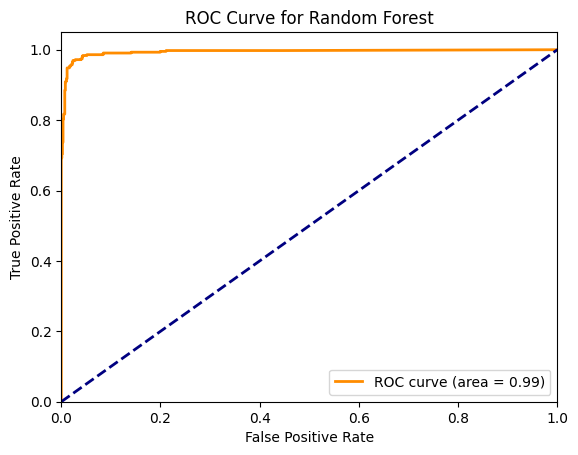

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

def plot_roc_curve(model, X_test, y_test, model_name):
    # Binarize the output labels if more than two classes
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    y_score = model.predict_proba(X_test)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Asegurarse de ajustar el modelo
ovr_rf = OneVsRestClassifier(rf)
ovr_rf.fit(X_train, y_train)
plot_roc_curve(ovr_rf, X_test, y_test, "Random Forest")


## Ejemplo de uso de pipeline

 El pipeline simplifica el flujo de trabajo y asegura que los datos pasen por el mismo preprocesamiento durante tanto el entrenamiento como la evaluación. Además, se garantiza que las técnicas de preprocesamiento y las configuraciones del modelo se validen adecuadamente juntas durante la validación cruzada.

 Utilización de RandomizedSearchCV

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Cargar datos
df = pd.read_csv("https://github.com/ulewis/Ejemplos/raw/main/Datos/fetal_health.csv")
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Definir el pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Paso de preprocesamiento
    ('classifier', RandomForestClassifier(random_state=0))  # Paso del modelo
])

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_features': ['log2', 'sqrt'],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__bootstrap': [True, False]
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=100,
    cv=3,
    random_state=31,
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo usando el pipeline y la búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

# Extraer y mostrar los mejores hiperparámetros
print("Mejores Hiperparámetros:", random_search.best_params_)
print("Mejor Puntuación (Mean Test Score):", random_search.best_score_)

# Evaluar el modelo ajustado sobre el conjunto de prueba
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mejores Hiperparámetros: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 30, 'classifier__bootstrap': False}
Mejor Puntuación (Mean Test Score): 0.9376515165678887
              precision    recall  f1-score   support

         1.0       0.98      0.98      0.98       343
         2.0       0.88      0.84      0.86        50
         3.0       0.91      0.94      0.93        33

    accuracy                           0.96       426
   macro avg       0.92      0.92      0.92       426
weighted avg       0.96      0.96      0.96       426

